This tutorial guides you on how to do an image segmentation task.

Reference:
* Image Segmentation: https://www.tensorflow.org/tutorials/images/segmentation
* Pix2Pix on Tensorflow Examples: https://github.com/tensorflow/examples.git

In [0]:
!pip install -q tf-nightly

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

tfds.disable_progress_bar()

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200208
GPU is available.


# Image Segmentation

The image segmentation task is to find the shape of the object in the image. In detail, segment the image is to give a label to each pixel. Thus, the task of image segmentation is to train a NN to output a pixel-wise mask of the image.

The dataset `Oxford-IIIT Pet Dataset` (https://www.robots.ox.ac.uk/~vgg/data/pets/) is used for this tutorial. The dataset is composed of three components, images, corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is in one of three categories.
* Class 1: Pixel is belonging to the Pet.
* Class 2: Pixel is bordering the Pet.
* Class 3: None of the above. 

# Data Preprocessing

In [0]:
dataset, info = tfds.load(name="oxford_iiit_pet:3.*.*", 
                          with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incomplete0FPR9K/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incomplete0FPR9K/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


In [0]:
dataset

{'test': <DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

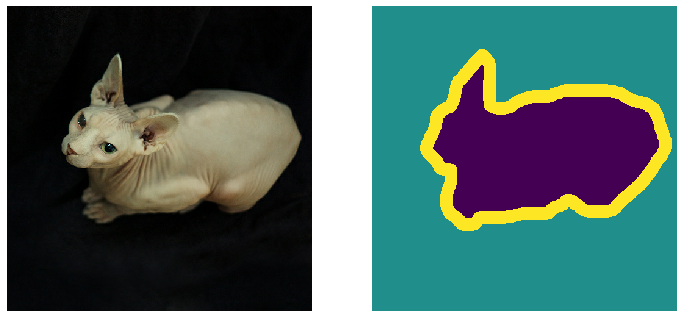

In [0]:
for datapoint in dataset['train'].take(1):
  fname = datapoint['file_name']
  image = datapoint['image']
  label = datapoint['label']
  mask = datapoint['segmentation_mask']
  species = datapoint['species']

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(mask-1))
  plt.axis("off")
  plt.show()

The label of each pixel in the mask is one of the categories (1,2,3). For the sake of convenience, subtract 1 from the masking label.

In [0]:
def normalize_and_preprocess_label(image, mask):
  img = tf.cast(image, tf.float32) / 255.0
  msk = mask - 1
  return img, msk

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  # data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize_and_preprocess_label(input_image, input_mask)
  return input_image, input_mask

In [0]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize_and_preprocess_label(input_image, input_mask)
  return input_image, input_mask 

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCHS = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's inspect the dataset.

In [0]:
def display(datapoint_list):
  title = ['Image', 'Mask', 'Prediction']
  plots = len(datapoint_list)
  plt.figure(figsize=(5*plots, 5))
  for i in range(plots):
    plt.subplot(1, plots, i+1)
    img = tf.keras.preprocessing.image.array_to_img(datapoint_list[i])    
    plt.title("{} size:{}".format(title[i], np.array(img).shape))
    plt.imshow(img)
    plt.axis("off")
  plt.show()

In [0]:
for image, mask in train.take(1):
  display([image, mask])

# Define the Model

The model used here is a modified U-Net. The U-Net architecture is composed of an encoder (downsampler) and a decoder (upsampler). In order to learn robust features, reduce the number of trainable variables and reduce the learning time, the encoder can be a pretrained model, which is a pre-trained MobileNetV2 here.

The `OUTPUT_CHANNEL` defined here is because the mask is labeled with three different categories (1, 2, 3). You can regard the number of the channel as a categorical problem.

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], 
                                               include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Use the activations of these layers.

In [0]:
layer_names = [
  'block_1_expand_relu',     # 64x64
  'block_3_expand_relu',     # 32x32
  'block_6_expand_relu',     # 16x16
  'block_13_expand_relu',    # 8x8
  'block_16_project'         # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

Create the feature extraction model.

In [0]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

Define the de-convolutional layer.

In [0]:
def DeConv2D_block(filters, ksize):
  """Here we apply the batch normalization."""
  initializer = tf.random_normal_initializer(0., 0.02)

  model = tf.keras.Sequential()
  model.add(
    tf.keras.layers.Conv2DTranspose(
      filters=filters, kernel_size=ksize, strides=(2, 2), padding="same",
      kernel_initializer=initializer, use_bias=False)
  )
    
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.ReLU())

  return model

In [0]:
up_stack = [
  DeConv2D_block(filters=512, ksize=(3, 3)),  # 4x4 => 8x8
  DeConv2D_block(filters=256, ksize=(3, 3)),  # 8x8 => 16x16
  DeConv2D_block(filters=128, ksize=(3, 3)),  # 16x16 => 32x32
  DeConv2D_block(filters=64, ksize=(3, 3)),   # 32x32 => 64x64
]

Define the U-Net model.

In [0]:
def unet_model(output_channels=3):
  inputs = tf.keras.layers.Input(shape=(128, 128, 3))
  x = inputs

  # Down-Sampling
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Up-Sampling and Establishing the Skip Connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  # last layer of the model for masking
  mask = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=(2, 2), padding="same"
  )  # 64x64 => 128x128

  return tf.keras.Model(inputs, mask(x))

# Train the Model

Here the loss function is set to `tf.keras.losses.SparseCategoricalCrossentropy`. Such settings match the parameter filters (or output channels) with the number of mask predictions (here are in the set {1,2,3} for each pixel).

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [0]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_18[0][0]                   
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 512)    1476608     model[6][4]                      
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 8, 8, 1088)   0           sequential_4[2][0]               
                                                                 model[6][3]               

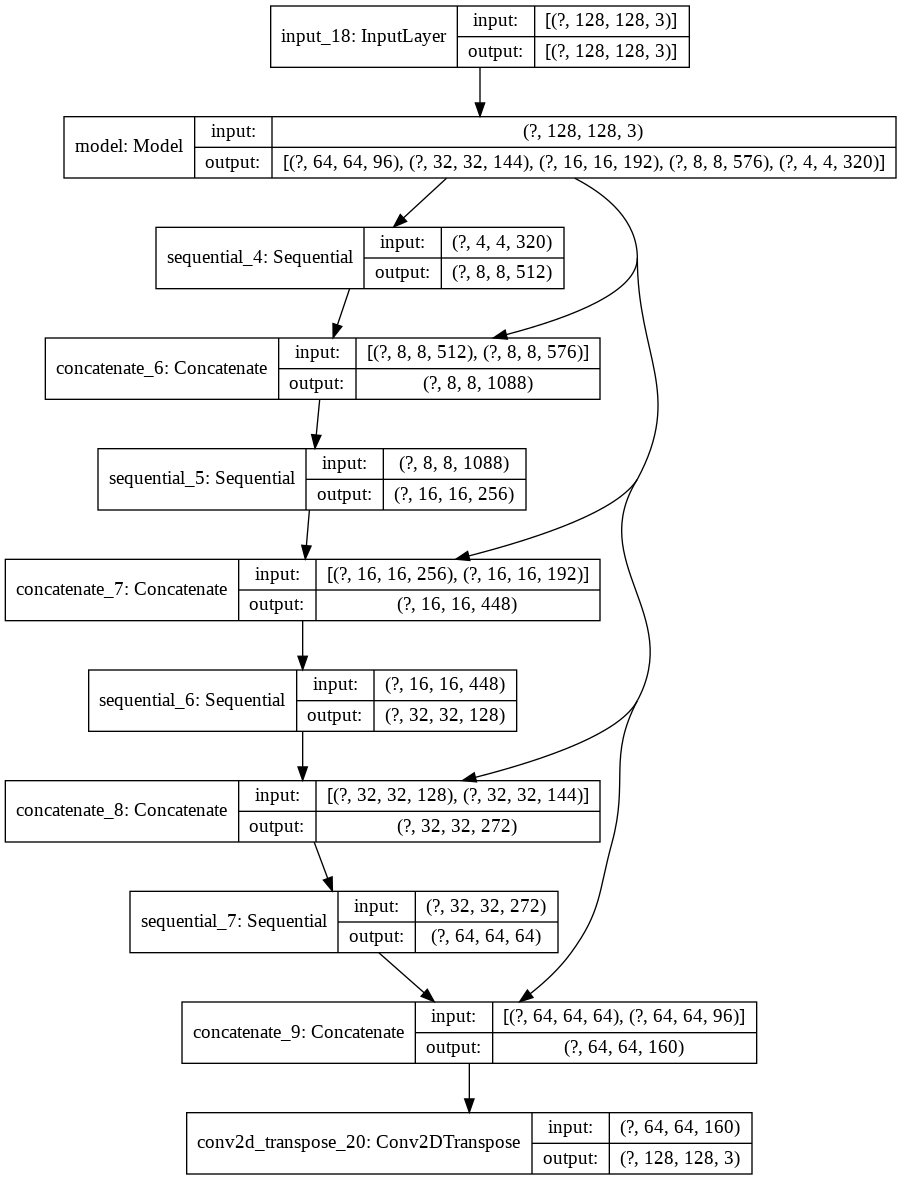

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try the inference first.

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]  # (128, 128, 1)

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    for image, mask in train.take(1):
      display([image, mask, 
               create_mask(model.predict(image[tf.newaxis, ...]))])

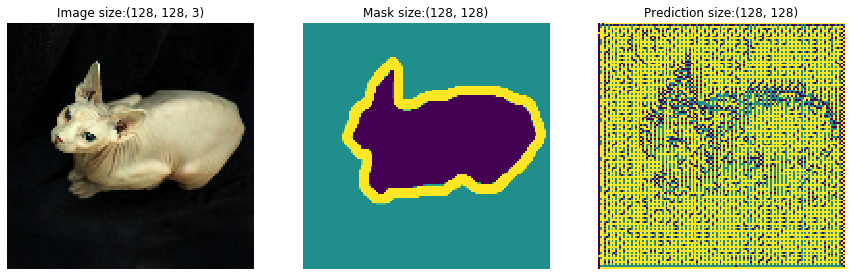

In [0]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print("\nSample Prediction After epoch {}\n".format(epoch+1))

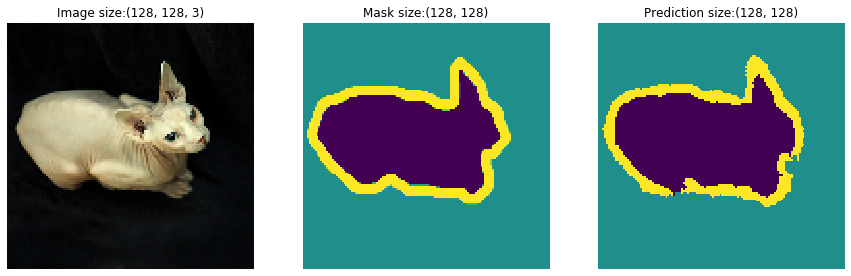


Sample Prediction After epoch 20

57/57 [==============================] - 14s 252ms/step - loss: 0.1423 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.3831 - val_sparse_categorical_accuracy: 0.8752


In [0]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, 
                          epochs=EPOCHS, 
                          steps_per_epoch=STEPS_PER_EPOCHS, 
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [0]:
model_history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

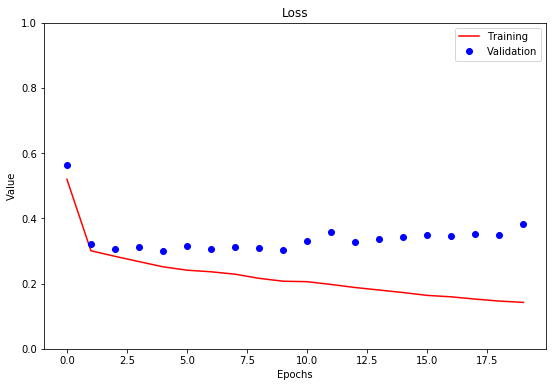

In [0]:
plt.figure(figsize=(9, 6))
plt.plot(range(EPOCHS), model_history.history['loss'], 'r', label="Training")
plt.plot(range(EPOCHS), model_history.history['val_loss'], 'bo', label="Validation")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.ylim([0, 1])
plt.legend(loc="upper right")
plt.show()

# Make Prediction

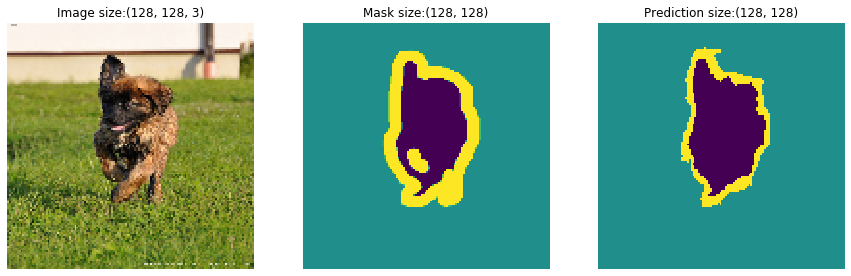

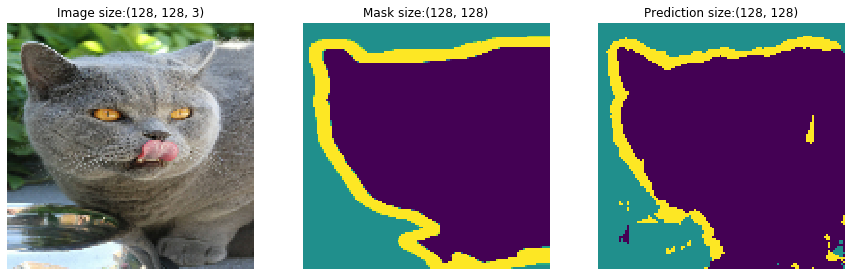

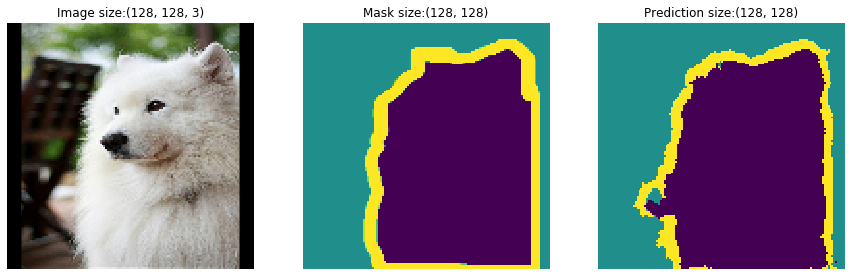

In [0]:
show_predictions(test_dataset, num=3)